# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: ***сохранять текущих клиентов дешевле, чем привлекать новых.*** \
На основе текущих данных было спрогнозировано - уйдёт клиент или нет\

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Импорт

### Импорт библиотек

In [1]:
!pip install imblearn
!pip install sklearn

In [2]:
from io import BytesIO
from IPython.display import clear_output

import re

import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

### Импорт данных

In [3]:
try:
    data_rate = pd.read_csv('../datasets/Churn.csv')
except:
    pass

In [4]:
RANDOM_STATE = 12345

SCORING = ['f1', 'roc_auc','accuracy', 'recall','precision']
MAIN_SCORING = 'f1'

## Анализ данных

In [5]:
data_rate.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
data_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Преобразуем названия столбцов в shake_case

In [7]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [8]:
data_rate.columns = [camel_to_snake(col) for col in data_rate.columns]

Мы видим, что в данных присутствуют пропуски. Таким образом данным нужна будет предобработка

In [ ]:
(pd.concat(
    [data_rate.isna().sum(), data_rate.isna().sum() / data_rate.shape[0]],axis = 1)
    .rename(columns = {0:"count",1:'percent'})
    .style.format({'percent': '{:,.2%}'.format})
    )

,count,percent
row_number,0,0.00%
customer_id,0,0.00%
surname,0,0.00%
credit_score,0,0.00%
geography,0,0.00%
gender,0,0.00%
age,0,0.00%
tenure,909,9.09%
balance,0,0.00%
num_of_products,0,0.00%


Доля пропусков составляет приблизительно 9 процентов, так просто удалить их не получится \
Предположим, что эти пропуски связаны с тем, что пропуски проставляются, когда человек не является клиентом банка

Посмотрим распределение данных

<AxesSubplot:>

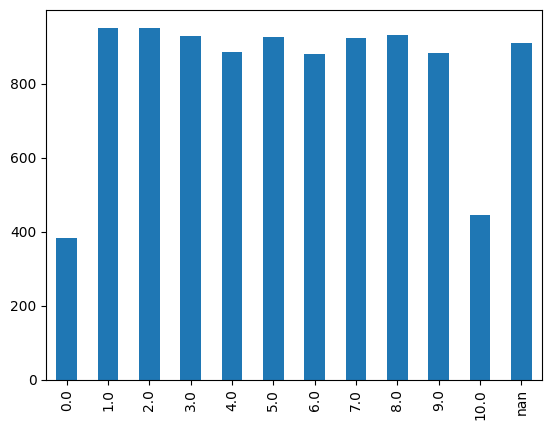

In [ ]:
(data_rate.tenure
    .value_counts(dropna = False)
    .sort_index()
    .plot(kind = 'bar'))

Мы видим, что в целом данные распределены равномерно и отклонений нет

In [ ]:
data_rate[data_rate.tenure.isna()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Проверим дубликаты

In [ ]:
data_rate['customer_id'].duplicated().sum()

0

Явных закономерностей меduplicatedу пропущенным значением и данными не наблюдается

<AxesSubplot:>

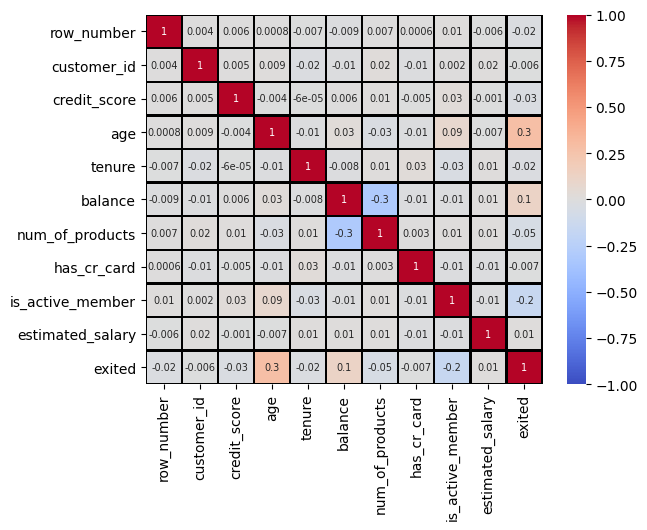

In [ ]:
sns.heatmap(data_rate.corr(),
            annot = True,
            fmt='.1g',
            annot_kws={"fontsize":7},
            linecolor = 'black',
            linewidths=1, 
            vmin=-1, vmax=1, center= 0,
            cmap= 'coolwarm')

Корреляций между признаками не наблюдается

In [ ]:
data_rate['is_na_value'] = 0
data_rate.loc[data_rate.tenure.isna(),'is_na_value'] = 1

In [ ]:
data_rate.corr()['is_na_value']

row_number         -0.014691
customer_id        -0.004950
credit_score       -0.006798
age                -0.008257
tenure                   NaN
balance            -0.001868
num_of_products     0.000029
has_cr_card         0.003587
is_active_member   -0.002941
estimated_salary   -0.005003
exited             -0.001869
is_na_value         1.000000
Name: is_na_value, dtype: float64

In [ ]:
del data_rate['is_na_value']

Выше я проверил корреляцию признаков путем введения нового столбца. Корреляция между признаками не наблюдается

## Подготовка данных

Выделение категориальных и количественных признаков

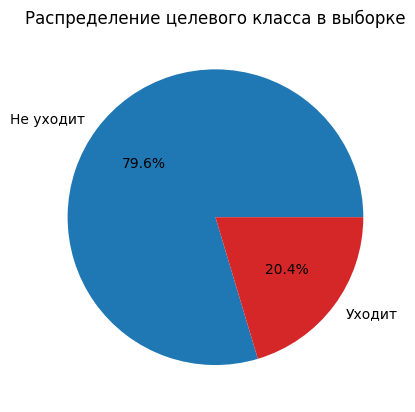

In [ ]:
plt.pie(data_rate['exited'].value_counts(normalize = True),
        autopct='%1.1f%%', labels = ["Не уходит","Уходит"], colors = ['C10','C3'],)
plt.title("Распределение целевого класса в выборке")
plt.show()

Классы несбалансированы

---
⚠ Изначально задумывается, что в проекте будут использоваться Pipeline и Кросс валидация \
Поэтому будет предпринято ряд решение
- Для обработки пропусков будем использовать встроенные инструменты sklearn
- Для Кросс валидации будем использовать GridSearchCV, но так как классы не сбалансированы \
в параметр cv будет передавать StratifiedKFold (cross-validation generator). Согласно документации данный генератор сохраняет процентное соотношение классов

---

### Удаление колонок, которые не смогут нам помочь при обучении модели

Удаляем фамилию, так как она никакой смысловой нагрузки не несет. Тем более, что гендер у нас уже определен отдельной колонкой

In [ ]:
del data_rate['surname']

Также удалим столбцы `RowNumber` и `CustomerId`

In [ ]:
del data_rate['row_number']
del data_rate['customer_id']

### Разделение выборки на обучающую и валидационную

In [ ]:
X = data_rate.drop('exited', axis = 1)
y = data_rate['exited']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        X,y, test_size=.25, stratify = y, random_state = RANDOM_STATE)

In [ ]:
# находим все числовые колонки
numerical_cols = [cname for cname in X_train.columns
                  if X_train[cname].dtype in ['int64', 'float64']]


In [ ]:
# Находим все категориальные колонки
categorical_cols = [cname for cname in X_train.columns
                    if X_train[cname].dtype in ['object']]

Проверим сколько значений находится в категориальных данных

In [ ]:
data_rate[categorical_cols].nunique()

geography    3
gender       2
dtype: int64

### Создание Pipeline для предобработки данных

 Используем IterativeImputer для обработки пропущенных значений. Данный способ заполняет значения на основе других данных \
 Также следущим шагом применяем StandartScaler для приведения данных к одинаковому масштабу

---

⚠ Почему был использован именно этот метод?
он при заполнении учитывает другие колонки.
Конечно можно было бы добавить колонку, в которой было бы
отдельно написано был или нет пропуск, но мы предполагаем исходя из предыдущих данных и логики задачи, что в данном
датасете пропуски случайны и не имеют закономерности. Скорее всего это ошибка в сборе данных

---

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('inputer',IterativeImputer(random_state=0, max_iter=40)),
    ('scaler',StandardScaler())])

In [ ]:
# передаем drop значение first, чтобы избежать ошибку dummy ловушки
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop= 'first'))
])

In [ ]:
# далее объединяем два шага в один preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
# Функция для удобной передачи модели и сразу получение модели с предобработанными
# данными
def get_pipeline_model(model):
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('model', model)
                             ])
    return model_pipeline

In [ ]:
# cross-validation generator, который будем передавать в Grid_search,
# для того, чтобы модель верно обучалась при дисбалансе классов
strat_kfold = StratifiedKFold(n_splits = 5)

### Создание функции для вывода отчета

In [ ]:
def return_report(model_grid_search_cv):
    """Функция создает отчет и печатает его и одновременно
    возвращает в результате метрики, чтобы их можно было сохранить
    и сравнить"""
    
    report_result = model_grid_search_cv.cv_results_
    best_index = model_grid_search_cv.best_index_
    
    print(f"accuracy:   {report_result['mean_test_accuracy'][best_index]:.4f}")
    print(f"precision:  {report_result['mean_test_precision'][best_index]:.4f}")
    print(f"recall:     {report_result['mean_test_recall'][best_index]:.4f}")
    print(f"f1_score:   {report_result['mean_test_f1'][best_index]:.4f}")
    print(f"roc_auc:    {report_result['mean_test_roc_auc'][best_index]:.4f}")
    print()

## Исследование моделей без учета дисбаланса

### Логистическая регрессия

Относится к линейным моделям. В целом если модель покажет себя на уровне других более продвинутых моделей, можно будет попробовать \
как-то поработать с линейными моделями. Хотя скорее всего данная модель не даст высоких результатов

In [ ]:
lgr = get_pipeline_model(LogisticRegression(random_state=RANDOM_STATE, 
                                            solver = 'liblinear'))
# указывать scoring явно не требуется, сделаем для лучшего понимания
g_lgr = GridSearchCV(lgr, param_grid = {}, cv = strat_kfold,
                     scoring = SCORING,refit = MAIN_SCORING)

""" cross_val_score - можно использовать как альтернативу, чтобы не передавать
пустой param_grid, но здесь не будем импортировать лишнюю функцию, чтобы 
не путаться 
""";

In [ ]:
g_lgr.fit(X_train, y_train)

return_report(g_lgr)

accuracy:   0.7917
precision:  0.4302
recall:     0.0445
f1_score:   0.0788
roc_auc:    0.6638



Ожидаемо данная модель показывает недостаточно хорошие результаты

- не смотря на высокий accuracy, метрика f1_score низкая. То есть мы не сможем достаточно точно предсказывать уйдет клиент или нет
- При этом roc_auc метрика говорит о том, что модель отличается от случайной

### Дерево решений

In [ ]:
dtr = get_pipeline_model(DecisionTreeClassifier(random_state=RANDOM_STATE))
# перед признаком указывается model, так как в pipeline необходимо указывать название
# объекта, куда будет передаваться признак
param_grid_dtr = {'model__max_depth' : range(2,30)}

g_dtr = GridSearchCV(dtr, param_grid = param_grid_dtr, 
                     cv = strat_kfold, scoring = SCORING, refit = MAIN_SCORING)


In [ ]:
g_dtr.fit(X_train, y_train);
print(f"Лучшее f1 дерева решений: {g_dtr.best_score_:.4f}")

Лучшее f1 дерева решений: 0.5617


In [ ]:
return_report(g_dtr)

accuracy:   0.8541
precision:  0.7229
recall:     0.4607
f1_score:   0.5617
roc_auc:    0.8272



Дерево решений

- все показатели превышают показатели линейной регрессии
- мы видим, что f1-score в разы выше предыдущей модели
- при этом показатель roc_auc ниже, чем у линейной регрессии

### Случайный лес

In [ ]:
rfc = get_pipeline_model(RandomForestClassifier(random_state=RANDOM_STATE))

param_grid_rfc = {'model__max_depth' : range(2,15),
                  'model__n_estimators':range(5,50,10),
                  'model__min_samples_leaf':[1,5,10,20]}

#accuracy
g_rfc = GridSearchCV(rfc, param_grid = param_grid_rfc, 
                     cv = strat_kfold, scoring = SCORING, refit = MAIN_SCORING)

In [37]:
g_rfc.fit(X_train, y_train);

print('Подбор гиперпараметров завершен')

Подбор гиперпараметров завершен


In [38]:
return_report(g_rfc)

accuracy:   0.8647
precision:  0.7988
recall:     0.4483
f1_score:   0.5739
roc_auc:    0.8511



Мы видим, что приблизиться к нужной f1 мере у нас не получилось

## Борьба с дисбалансом

### Взвешивание классов

#### Логистическая регрессия

Во многих моделях существует class_weight. И если указать class_weight, то можно будет увеличить вес класса, который меньше

In [39]:
lgr = get_pipeline_model(LogisticRegression(random_state=RANDOM_STATE, 
                                            solver = 'liblinear',
                                            class_weight='balanced'))

g_lgr = GridSearchCV(lgr, param_grid = {}, cv = strat_kfold,
                     scoring = SCORING, refit = MAIN_SCORING)
g_lgr.fit(X_train, y_train);

return_report(g_lgr)

accuracy:   0.6881
precision:  0.3614
recall:     0.6905
f1_score:   0.4744
roc_auc:    0.7494



f1 мера улучшилась, но незначительно

#### Случайный лес

---

⚠ Дерево решений мы не будем проверять и проверим сразу случайный лес. Да мы знаем, что случайный лес менее чувствителен к дисбалансу классов. Но именно эта модель показала себя лучше остальных и мы постараемся улучшить её показатели

---

In [40]:
rfc_1 = get_pipeline_model(RandomForestClassifier(random_state=RANDOM_STATE,
                                           class_weight='balanced'))

param_grid_rfc = {'model__max_depth' : range(1,15),
                  'model__n_estimators':range(5,50,10),
                  'model__min_samples_leaf':[1,5,10,20]}

#accuracy
g_rfc_1 = GridSearchCV(rfc_1, param_grid = param_grid_rfc, 
                cv = strat_kfold, scoring = SCORING, refit = MAIN_SCORING)

g_rfc_1.fit(X_train, y_train);

print('Подбор гиперпараметров завершен')

Подбор гиперпараметров завершен


In [41]:
return_report(g_rfc_1)

accuracy:   0.8416
precision:  0.6048
recall:     0.6407
f1_score:   0.6220
roc_auc:    0.8473



---

⚠ Итак не смотря на кросс валидацию и то, что мы имеем дело с рандомным лесом, мы скорее всего столнулись с переобучением модели


---

### Увеличение выборки

In [42]:
# make_pipeline взял из библиотеки lmblearn. Из sklearn не работает SMOTE
def get_pipeline_model_smote(model):
    smote = make_pipeline(SMOTE(random_state = RANDOM_STATE),
                          model)

    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('smote', smote),
                             ])
    return model_pipeline

In [43]:
rfc_2 = get_pipeline_model_smote(
        RandomForestClassifier(random_state=RANDOM_STATE)
)


param_grid_rfc = {'smote__randomforestclassifier__max_depth' : range(1,12,2),
                  'smote__randomforestclassifier__n_estimators':range(5,50,10),
                  'smote__randomforestclassifier__min_samples_leaf':[1,5,10,20]}

#accuracy
g_rfc_2 = GridSearchCV(rfc_2, param_grid = param_grid_rfc, 
                cv = strat_kfold, scoring = SCORING, refit = MAIN_SCORING)


In [44]:
g_rfc_2.fit(X_train, y_train);

In [45]:
return_report(g_rfc_2)

accuracy:   0.8599
precision:  0.7113
recall:     0.5262
f1_score:   0.6043
roc_auc:    0.8508



Стоит заметить, что в данной модели мы сразу старались максимизировать f1 метрику

### Изменение порога приналежности к классу

In [46]:
probabilities_valid = g_rfc.predict_proba(X_train)
probabilities_one_valid = probabilities_valid[:, 1]

In [47]:
precision_list = []
recall_list = []
f1_list = []

for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision_list.append(precision_score(y_train, predicted_valid))
    recall_list.append(recall_score(y_train, predicted_valid))
    f1_list.append(f1_score(y_train, predicted_valid))
    

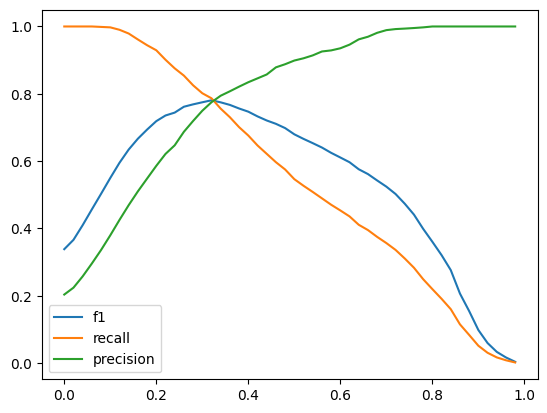

In [48]:
plt.plot(np.arange(0, 1, 0.02) , f1_list , label='f1')
plt.plot(np.arange(0, 1, 0.02) , recall_list , label='recall')
plt.plot(np.arange(0, 1, 0.02) , precision_list , label='precision')

plt.legend()
plt.show()

Итого при пороге 0.3 модель на выборке показывает себя наилучшим образом

## Тестирование модели

Применим исправленную модель, где была увеличена выборка, были сокращено количество долей, на которые разбивается датафрейм при кросс валидации и было ограничено количество деревьев и их глубина и обучение шло по f1 метрике

In [49]:
g_rfc_1.score(X_test, y_test)

0.6257088846880908

Также проверим, улучшится ли модель, если поменять порог

In [50]:
probabilities_test = g_rfc.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
pred_y_test = probabilities_one_test > 0.3

f1_score(y_test, pred_y_test)

0.6356011183597391

На тестовой выборке порог улудшил модель рандомного леса

## ИТОГО

1) Этап преобоработки
    - пропущенные признаки были предобработаны при помощи IterativeImputer
    - данные были разделены на обучающую и тестовую выборку
    - было применено масштабирование признаков при помощи ScandartScaler
    - категориальные признаки были обработаны при помощи OneHotEncoding, первый признак был удалён, чтобы избежать Dummy- ловушки
2) На протяжении всего исследования учитывалась метрика roc_auc
    - самый низкий показатель данной метрики был зафиксирован у логистической регрессии
    - в остальных случаях метрика была более 0.7, что отличает её от случайной
3) Итоговое f1 значение меры на тестовой выборке `0.63`
4) Для работы с дисбаланированными классами были применены следущие решения
    - при разбиении на обучающую и тестовую выборку был использован параметр stratify
    - при кросс-валидации использовался StratifiedKFold
    - был использован мето взвешивания классов, который значительно улучшил качество модели регрессии
    - был использован метод увеличения выборки(upsampling). Именно в корнечном итоге эта модель показала себя лучшим образом
    - также на модели рандомного леса было использовано изменение порога. Оно тоже показало неплохие результаты в плане f1 меры